In [ ]:
# Setup to equivalently run in colab or run locally
import sys
import os

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    %cd /content
    # Colab-specific widget support
    from google.colab import output
    output.enable_custom_widget_manager()
    !pip install ipympl --quiet
    !pip install sigpy --quiet
    %matplotlib widget

    # Clone repo and cd into it to behave like running locally
    if not os.path.exists("arc_zte"):
      print("Cloning repo")
      !git clone https://github.com/mikgroup/arc_zte.git
    %cd /content/arc_zte
else:
    # Local Jupyter 
    %matplotlib notebook

In [23]:
import numpy as np
import sigpy as sp
import matplotlib.pyplot as plt
import sigpy.plot as pl
import os
import glob

from zte_recon.data_zte import Data_Arc_ZTE
from zte_recon.recon_gridding import recon_adjoint_postcomp_coilbycoil
from zte_recon.arc_zte_traj import read_params_from_kacq
from zte_recon.plot import plot_coherence_pathways_from_coords

from arc_zte_sim.metrics import cov_uniformity_metric

In [4]:
# Acquisition parameters
dt_sampling = 8 # dwell time in us
grad_dt_sampling = 4 # grad sampling time period in us

# Reconstruction parameters
FOV_scale = 1
FOV_scale_dir = [1,1,1]
img_shape = [256,256,256]

# To account for coil ringing, drop extra points at spoke start
ndrop_ROpts = 1 

# Device for recon. -1 for CPU, else >= 0
device = 1 

# Load data

In [5]:
# Download phantom data from Zenodo

USE_ZENODO = False
local_data_path = '/mikLKS/shreya/data_for_arczte_paper/ge_phantom/'

if USE_ZENODO:
    
    print('Downloading data...')
    url = "https://zenodo.org/record/18307416/files/ge_phantom.zip?download=1"

    if not os.path.exists('ge_phantom'):
        # Download the specific zip
        !wget -q -O temp.zip "{url}"

        # Unzip into a folder
        !unzip -q temp.zip -d ge_phantom

        # Clean up the zip
        os.remove("temp.zip")
        print('Data is ready')
    else:
        print('Data was already downloaded')
        
    data_path = './ge_phantom'
    
else:
    data_path = local_data_path

In [9]:
# Golden angle rotations of Arc-ZTE segments
seg_rot_file = './rot_txt_files/seg_golden3d_rotMats.txt'

################

### Furthest theta_i's scheme - purely maximize coverage
h5_save_dir = local_data_path + 'furthest_angle53/'
kacq_file = glob.glob(h5_save_dir + 'kacq_arc_zte*')[-1]
params = read_params_from_kacq(kacq_file)

arc_angle = params['arc_angle']
a_grad = params['a_grad']
points_per_spoke = params['points_per_spoke']
points_before_curve = params['points_before_curve']

Furthest_thetas_data = Data_Arc_ZTE(None, seg_rot_file, arc_angle, points_per_spoke, 
                points_before_curve, dt_sampling, grad_dt_sampling, a_grad, kacq_file,
                h5_save_dir, FOV_scale=FOV_scale, FOV_scale_dir=FOV_scale_dir, 
                ndrop_ROpts=ndrop_ROpts)
Furthest_thetas_data.gradient_corr(-0.25)

################

### Random theta_i's scheme - choose randomly
h5_save_dir = local_data_path + 'random_angle53/'
kacq_file = glob.glob(h5_save_dir + 'kacq_arc_zte*')[-1]
params = read_params_from_kacq(kacq_file)

arc_angle = params['arc_angle']
a_grad = params['a_grad']
points_per_spoke = params['points_per_spoke']
points_before_curve = params['points_before_curve']

Random_thetas_data = Data_Arc_ZTE(None, seg_rot_file, arc_angle, points_per_spoke, 
                points_before_curve, dt_sampling, grad_dt_sampling, a_grad, kacq_file,
                h5_save_dir, FOV_scale=FOV_scale, FOV_scale_dir=FOV_scale_dir, 
                ndrop_ROpts=ndrop_ROpts)
Random_thetas_data.gradient_corr(-0.25)

################

### Optimization-based scheme to choose theta_i's
h5_save_dir = local_data_path + 'optim_angle53/'
kacq_file = glob.glob(h5_save_dir + 'kacq_arc_zte*')[-1]
params = read_params_from_kacq(kacq_file)

arc_angle = params['arc_angle']
a_grad = params['a_grad']
points_per_spoke = params['points_per_spoke']
points_before_curve = params['points_before_curve']

Optim_thetas_data = Data_Arc_ZTE(None, seg_rot_file, arc_angle, points_per_spoke, 
                points_before_curve, dt_sampling, grad_dt_sampling, a_grad, kacq_file,
                h5_save_dir, FOV_scale=FOV_scale, FOV_scale_dir=FOV_scale_dir, 
                ndrop_ROpts=ndrop_ROpts)
Optim_thetas_data.gradient_corr(-0.25)

Loading ksp from h5 dir: /mikLKS/shreya/data_for_arczte_paper/ge_phantom/furthest_angle53/
Setting nPtsPerSpoke to opxres 256
Applied gradient delay correction of -0.25
Loading ksp from h5 dir: /mikLKS/shreya/data_for_arczte_paper/ge_phantom/random_angle53/
Setting nPtsPerSpoke to opxres 256
Applied gradient delay correction of -0.25
Loading ksp from h5 dir: /mikLKS/shreya/data_for_arczte_paper/ge_phantom/optim_angle53/
Setting nPtsPerSpoke to opxres 256
Applied gradient delay correction of -0.25


# Coverage uniformity metrics

In [20]:
nSpk = Optim_thetas_data.spokes_per_seg

print(f"Furthest thetas: U = {cov_uniformity_metric(Furthest_thetas_data.coord_radial_spokes[0:nSpk, -1], n=3000):.2e}")
print(f"Random thetas: U = {cov_uniformity_metric(Random_thetas_data.coord_radial_spokes[0:nSpk, -1], n=3000):.2e}")
print(f"Optimized thetas: U = {cov_uniformity_metric(Optim_thetas_data.coord_radial_spokes[0:nSpk, -1], n=3000):.2e}")

Furthest thetas: U = 1.14e+00
Random thetas: U = 9.65e-01
Optimized thetas: U = 1.10e+00


# Plot coherence pathways

<IPython.core.display.Javascript object>


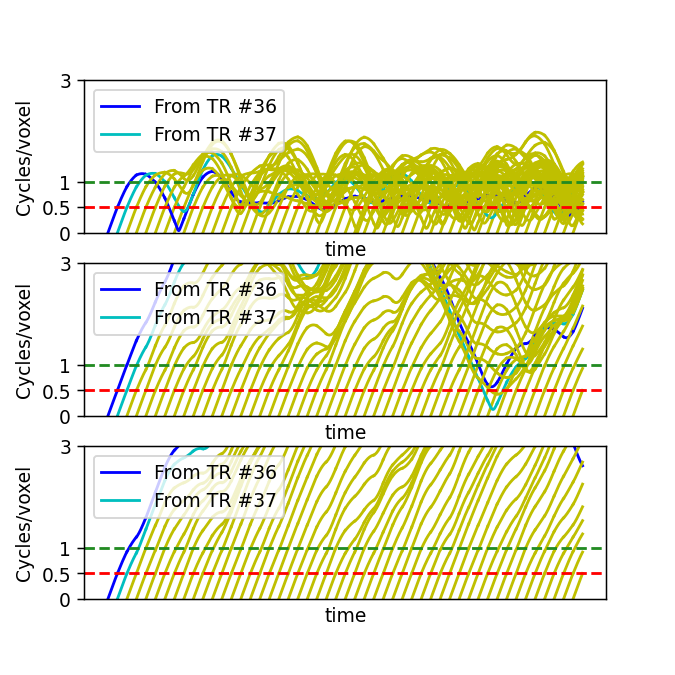

In [47]:
nSpokes_plot = 50
spoke_start_idx = 35

plt.figure(figsize=(5,5))
ax1 = plt.subplot(311)
plot_coherence_pathways_from_coords(Furthest_thetas_data.coord_radial_spokes, nSpokes_plot, spoke_start_idx)

ax2 = plt.subplot(312)
plot_coherence_pathways_from_coords(Random_thetas_data.coord_radial_spokes, nSpokes_plot, spoke_start_idx)

ax3 = plt.subplot(313)
plot_coherence_pathways_from_coords(Optim_thetas_data.coord_radial_spokes, nSpokes_plot, spoke_start_idx)

# Gridding reconstruction of fully-sampled data

In [25]:
##################

# Combine waspi and hires spokes
ksp_hires_waspi, coord_hires_waspi = Furthest_thetas_data.combine_waspiHires_flat()
# Gridding reconstruction
coil_ims_furthest_thetas = recon_adjoint_postcomp_coilbycoil(ksp=ksp_hires_waspi, 
                                                        coord=coord_hires_waspi, 
                                                        img_shape=img_shape, 
                                                        oversamp=2, norm="ortho", 
                                                        device=device)
# coil combination
im_furthest_thetas_grid = sp.rss(coil_ims_furthest_thetas, axes=0) 

##################

# Combine waspi and hires spokes
ksp_hires_waspi, coord_hires_waspi = Random_thetas_data.combine_waspiHires_flat()
# Gridding reconstruction
coil_ims_random_thetas = recon_adjoint_postcomp_coilbycoil(ksp=ksp_hires_waspi, 
                                                        coord=coord_hires_waspi, 
                                                        img_shape=img_shape, 
                                                        oversamp=2, norm="ortho", 
                                                        device=device)
# coil combination
im_random_thetas_grid = sp.rss(coil_ims_random_thetas, axes=0)

###################

# Combine waspi and hires spokes
ksp_hires_waspi, coord_hires_waspi = Optim_thetas_data.combine_waspiHires_flat()
# Gridding reconstruction
coil_ims_optim_thetas = recon_adjoint_postcomp_coilbycoil(ksp=ksp_hires_waspi, 
                                                        coord=coord_hires_waspi, 
                                                        img_shape=img_shape, 
                                                        oversamp=2, norm="ortho", 
                                                        device=device)
# coil combination
im_optim_thetas_grid = sp.rss(coil_ims_optim_thetas, axes=0)

Coil-by-coil Gridding recon: 100%|█| 12/12 [01:03<00:00,  5.30s/


Coil-by-coil recon finished


Coil-by-coil Gridding recon: 100%|█| 12/12 [01:02<00:00,  5.25s/


Coil-by-coil recon finished


Coil-by-coil Gridding recon: 100%|█| 12/12 [01:02<00:00,  5.21s/


Coil-by-coil recon finished


<IPython.core.display.Javascript object>


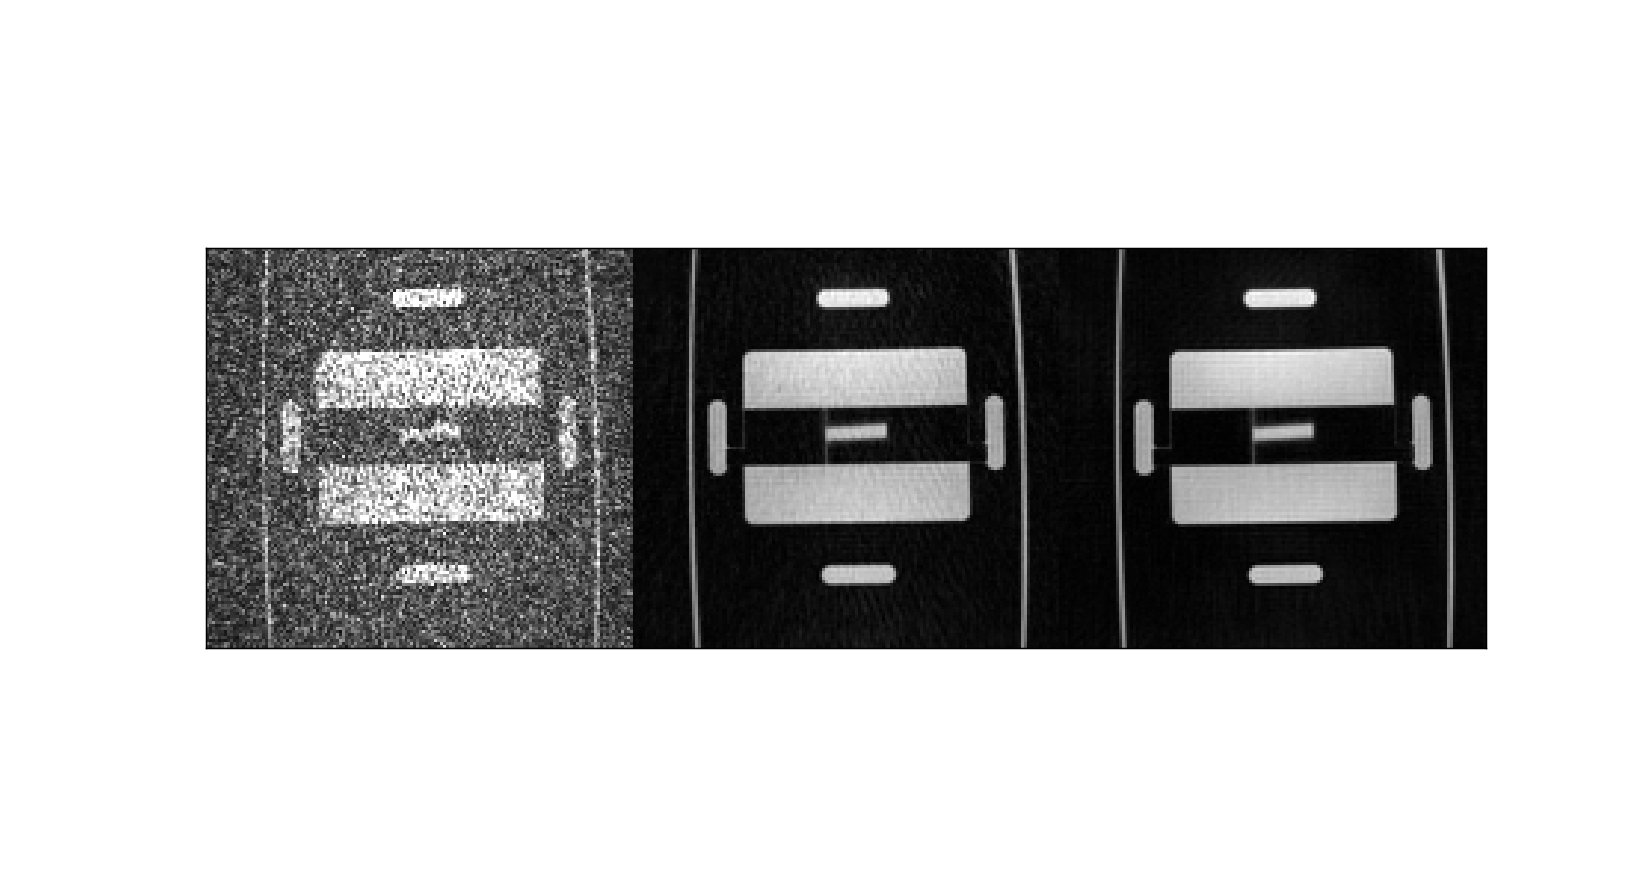

In [61]:
slice_num = 110
im_plot = np.stack((
                im_furthest_thetas_grid[56:200, slice_num, 75:210],
                im_random_thetas_grid[56:200, slice_num, 75:210], 
                im_optim_thetas_grid[56:200, slice_num, 75:210]), axis=0
           )
pl.ImagePlot(im_plot)